In [1]:
import sys
sys.path.append("/home/djl34/lab_pd/roulette/git/Roulette/validation")

In [2]:
import pseudo_R2
import pandas as pd
import dask.dataframe as dd
import numpy as np

import scipy.optimize
import scipy.stats as stats

In [3]:
def calc_pR2(sites, mutations, rates, distribution = None, polymorphism = True):
    bin_p = sites / np.sum(sites)
    
    # polymorphism = True if we use polymorphism, False if we use denovo data

    # Use a Poisson link to scale rates to the probability of observing a mutation
    # This is relevant if analyzing population data where recurrent mutation is likely
    
    if polymorphism:    
        def poisson_link(x):
            return -np.sum(stats.binom.logpmf(k=mutations,
                                              n=sites,
                                              p=(1 - np.exp(-x * rates))))
        # Find a non-awful starting place for optimization
        # Replace with ML estimate at some point
        x0 = np.array([-np.log(0.99) / np.max(rates)])
        scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                              options={'xatol': 1e-3, 'disp': False})
        scaling_factor = scaling_fit.x[0]

        mut_p = 1 - np.exp(-scaling_factor * rates)
    else:
        def poisson_link(x):
            return -np.sum(stats.binom.logpmf(k=mutations,
                                              n=sites,
                                              p=x * rates))
        # Find a non-awful starting place for optimization
        # Replace with ML estimate at some point
        x0 = np.array([-np.log(0.99) / np.max(rates)])
        scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                              options={'xatol': 1e-3, 'disp': False})
        scaling_factor = scaling_fit.x[0]

        mut_p = scaling_factor * rates
            
    # Calculate pseudo-R2 for the observed data
    if distribution is None:
        e_ll = pseudo_R2.exp_likelihood_model(mut_p, bin_p)
        e_ll_null = pseudo_R2.exp_likelihood_null(mut_p, bin_p)
    else:
        sites_d = distribution[0]
        mutations_d = distribution[1]
        rates_d = distribution[2]
        
        bin_p_d = sites_d / np.sum(sites_d)

        
        if polymorphism:    
            def poisson_link(x):
                return -np.sum(stats.binom.logpmf(k=mutations_d,
                                                  n=sites_d,
                                                  p=(1 - np.exp(-x * rates_d))))
            # Find a non-awful starting place for optimization
            # Replace with ML estimate at some point
            x0 = np.array([-np.log(0.99) / np.max(rates_d)])
            scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                                  options={'xatol': 1e-3, 'disp': False})
            scaling_factor = scaling_fit.x[0]

            mut_p_distribution = 1 - np.exp(-scaling_factor * rates_d)
        
        else:
            def poisson_link(x):
                return -np.sum(stats.binom.logpmf(k=mutations_d,
                                                  n=sites_d,
                                                  p=x * rates_d))
            # Find a non-awful starting place for optimization
            # Replace with ML estimate at some point
            x0 = np.array([-np.log(0.99) / np.max(rates_d)])
            scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                                  options={'xatol': 1e-3, 'disp': False})
            scaling_factor = scaling_fit.x[0]

            mut_p_distribution = scaling_factor * rates_d
        
        e_ll = pseudo_R2.exp_likelihood_model(mut_p_distribution, bin_p_d)
        e_ll_null = pseudo_R2.exp_likelihood_null(mut_p_distribution, bin_p_d)
        
    a_ll = pseudo_R2.avg_likelihood_sample(sites, mutations, mut_p)
#     a_ll_null = pseudo_R2.null_likelihood_sample(sites, mutations, mut_p, bin_p)

    
    max_R2 = pseudo_R2.calculate_R2(e_ll, e_ll_null)
    R2 = pseudo_R2.calculate_R2(a_ll, e_ll_null)
    pR2 = R2 / max_R2
    return max_R2, R2, pR2

In [4]:
# def run_pR2_sampling_persite(polymorphic):
#     _bootstrap = 1000

#     max_R2_s_s = []
#     R2_s_s = []
#     pR2_s_s = []


#     for i in range(n_bootstrap):

#         print(i)

#         df_carlson = pd.read_csv("data/sample_sites/"+ polymorphic + "_Carlson_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
#         df_gnomad = pd.read_csv("data/sample_sites/" + polymorphic + "_gnomAD_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
#         df_roulette = pd.read_csv("data/sample_sites/" + polymorphic + "_mu_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1, 2])

#         df_list = [df_roulette, df_carlson, df_gnomad]

#         for df in df_list:
#             df.columns = ["rate", "sites", "mutations"]

#         distribution = [df_roulette["sites"].to_numpy(dtype=int), df_roulette["mutations"].to_numpy(dtype=int),df_roulette["rate"].to_numpy(dtype=float)]

#         max_R2_s = []
#         R2_s = []
#         pR2_s = []

#         for df in df_list:
#             rates = df["rate"].to_numpy(dtype=float)
#             sites = df["sites"].to_numpy(dtype=int)
#             mutations = df["mutations"].to_numpy(dtype=int)

#             max_R2, R2, pR2 = calc_pR2(sites, mutations, rates, distribution)

#             max_R2_s.append(max_R2)
#             R2_s.append(R2)
#             pR2_s.append(pR2)

#         max_R2_s_s.append(max_R2_s)
#         R2_s_s.append(R2_s)
#         pR2_s_s.append(pR2_s)
        
#     df_summary = pd.DataFrame(pR2_s_s, columns = ["Roulette", "Carlson", "gnomAD"])

#     df_summary["Roulette - Carlson"] = df_summary["Roulette"] - df_summary["Carlson"]
#     df_summary["Roulette - gnomAD"] = df_summary["Roulette"] - df_summary["gnomAD"]

#     df_summary.to_csv(polymorphic + "_pR2_1000.tsv", sep = "\t", index = None)
    
#     return df_summary

In [4]:
pr2_dir = "/home/djl34/lab_pd/roulette/data/pR2/"

In [5]:
dataset_list = ["denovo_all_mut", "gnomad", "ukb"]
dataset_list = ["denovo_all_mut", "gnomad", "ukb"]

In [6]:
mut_models = ["mu", "carlson", "gnomad"]

In [17]:
# dataset_list = ["gnomad"]
# mut_models = ["mu", "carlson"]

In [7]:
pR2_list_of_list = []

for dataset in dataset_list:
    if "denovo" in dataset:
        polymorphism = False
    else:
        polymorphism = True
    pR2_list = []
    
    for mut in mut_models:
        print(mut)
        df_all = dd.read_csv(pr2_dir + "noncoding_all_*_" + mut + ".tsv", sep = "\t")

        print(df_all.npartitions)

        df_all = df_all.compute()

        df_all = df_all.groupby("rate").sum().reset_index()
        df_all.columns = ["rate", "sites"]

        df_mut = dd.read_csv(pr2_dir + "noncoding_" + dataset + "_*_" + mut + ".tsv", sep = "\t")

        print(df_mut.npartitions)

        df_mut = df_mut.compute()

        df_mut = df_mut.groupby("rate").sum().reset_index()

        df = df_all.merge(df_mut, on = "rate", how = "left")
        df["mutations"] = df["mutations"].fillna(0)

        rates = df["rate"].to_numpy(dtype=float)
        sites = df["sites"].to_numpy(dtype=int)
        mutations = df["mutations"].to_numpy(dtype=int)

        if mut == "mu":
            distribution = [sites, mutations, rates]

        max_R2, R2, pR2 = calc_pR2(sites, mutations, rates, distribution, polymorphism = polymorphism)
        print(max_R2, R2)

        pR2_list.append(pR2)
        
    pR2_list_of_list.append(pR2_list)

mu
22
22
2.995485883416915e-05 3.313729327381054e-05
carlson
22
22
2.995485883416915e-05 3.221608017167643e-05
gnomad
22
22
2.995485883416915e-05 3.020966508038292e-05
mu
22
22
0.055725684267651454 0.057097358638848794
carlson
22
22
0.055725684267651454 0.0542869119984839
gnomad
22
22
0.055725684267651454 0.048013594157832795
mu
22
22
0.06559598721962512 0.06506599373227118
carlson
22
22
0.06559598721962512 0.0618845835938856
gnomad
22
22
0.06559598721962512 0.054177335065538124


In [14]:
df = pd.DataFrame(pR2_list_of_list, columns = ["Roulette", "Carlson", "gnomAD"], index = ["de novo", "gnomAD.v3", "UKBiobank"])

In [34]:
df_melt_combined_pr2

,Model,pR2,Dataset
0,Roulette,1.106241,de novo
1,Carlson,1.075488,de novo
2,gnomAD,1.008506,de novo
0,Roulette,1.024615,gnomAD.v3
1,Carlson,0.974181,gnomAD.v3
2,gnomAD,0.861606,gnomAD.v3
0,Roulette,0.991920,UKBiobank
1,Carlson,0.943420,UKBiobank
2,gnomAD,0.825925,UKBiobank


In [24]:
dataset = ["de novo", "gnomAD.v3", "UKBiobank"]

for i in range(3):
    df_summary = pd.DataFrame([pR2_list_of_list[i]], columns = ["Roulette", "Carlson", "gnomAD"])
    
    df_melt_pr2 = pd.melt(df_summary, value_vars=['Roulette', 'Carlson', 'gnomAD'], var_name="Model", value_name='pR2')
    
    df_melt_pr2["Dataset"] = dataset[i]

    if i == 0:
        df_melt_combined_pr2 = df_melt_pr2
    else:
        df_melt_combined_pr2 = pd.concat([df_melt_combined_pr2, df_melt_pr2])
        
    i += 1

## generate supp figure

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None, font_scale=2)
sns.despine(bottom = True, left = True)

<Figure size 640x480 with 0 Axes>

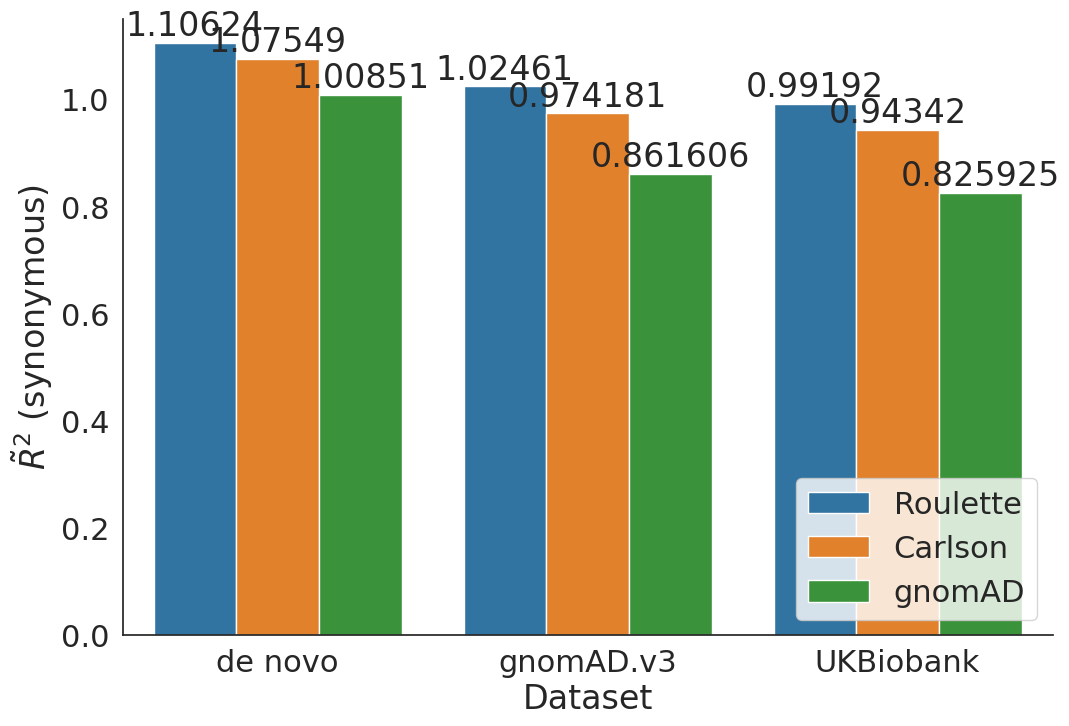

In [41]:
plt.subplots(figsize=(12, 8))
# ax = sns.pointplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model", errorbar=('pi', 95))
ax = sns.barplot(df_melt_combined_pr2, y="pR2", x="Dataset", hue="Model")
# ax = sns.barplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0.0, 1.15)
plt.legend(loc='lower right')
ax.set_ylabel(r"$\tilde{R}^2$ (synonymous)")
# ax.get_legend().remove()


for container in ax.containers:
    ax.bar_label(container)
    
plt.savefig("supp_figure_pR2.svg", format="svg", bbox_inches="tight")



In [38]:
for i in container:
    print(i)

Rectangle(xy=(0.133333, 0), width=0.266667, height=1.00851, angle=0)
Rectangle(xy=(1.13333, 0), width=0.266667, height=0.861606, angle=0)
Rectangle(xy=(2.13333, 0), width=0.266667, height=0.825925, angle=0)
